In [ ]:
import os
import sys
import webbrowser
from threading import Timer

# Add parent directory (where KG_dashboard lives) to path
sys.path.append('..')

# ✅ Now import the app from the dashboard module
from KG_dashboard import app_enhanced
app = app_enhanced.app

# Optional: auto-open browser
def open_browser():
    webbrowser.open('http://localhost:5757')

if __name__ == "__main__":
    print("Current working directory:", os.getcwd())
    Timer(1.5, open_browser).start()
    app.run(port=5757, debug=True, use_reloader=False)

Current working directory: /Users/ghadena/Desktop/geopol/notebooks
 * Serving Flask app 'KG_dashboard.app_enhanced'
 * Debug mode: on


 * Running on http://127.0.0.1:5757
Press CTRL+C to quit
127.0.0.1 - - [14/May/2025 18:47:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/May/2025 18:47:37] "GET /static/js/graph.js HTTP/1.1" 200 -
127.0.0.1 - - [14/May/2025 18:47:37] "GET /data?sentiment=All&relationship=All&search=&start_date=&end_date=&direction=all HTTP/1.1" 200 -


In [42]:
%tb

SystemExit: 1

# graph analytics

In [18]:
import pandas as pd
import networkx as nx
from community import community_louvain

# Load your data
edges_df = pd.read_csv("edges.csv")
entities_df = pd.read_csv("entities.csv")
entities_df = entities_df.drop_duplicates(subset="entity")

# Clean column names just in case
edges_df.columns = edges_df.columns.str.strip().str.lower()
entities_df.columns = entities_df.columns.str.strip().str.lower()

# Create directed graph from edges
G = nx.from_pandas_edgelist(edges_df, source="source", target="target", create_using=nx.DiGraph())

# --- Node-level metrics ---
degree_centrality = nx.degree_centrality(G)
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
partition = community_louvain.best_partition(G.to_undirected())

# Create node-level DataFrame
node_metrics = pd.DataFrame({
    "entity": list(G.nodes()),
    "degree_centrality": [degree_centrality.get(n, 0) for n in G.nodes()],
    "in_degree": [in_degree.get(n, 0) for n in G.nodes()],
    "out_degree": [out_degree.get(n, 0) for n in G.nodes()],
    "betweenness": [betweenness.get(n, 0) for n in G.nodes()],
    "eigenvector": [eigenvector.get(n, 0) for n in G.nodes()],
    "community": [partition.get(n, -1) for n in G.nodes()],
})

# Join with entity types if available
node_metrics = node_metrics.merge(
    entities_df.rename(columns={"entity": "entity", "entity_type": "type"}),
    on="entity",
    how="left"
)

# --- Graph-level metrics ---
graph_summary = {
    "num_nodes": G.number_of_nodes(),
    "num_edges": G.number_of_edges(),
    "density": nx.density(G),
    "connected_components": nx.number_weakly_connected_components(G)
}

try:
    graph_summary["avg_shortest_path"] = nx.average_shortest_path_length(G)
except:
    graph_summary["avg_shortest_path"] = "Not connected"

# Display the node-level metrics
print("📊 Node-Level Metrics (first 10 rows):")
display(node_metrics.head(10))

# Display graph-level summary
print("\n🌐 Graph-Level Summary:")
for key, value in graph_summary.items():
    print(f"{key}: {value}")

📊 Node-Level Metrics (first 10 rows):


entity  degree_centrality  in_degree  out_degree  betweenness  \
0      Donald Trump           0.523050        368         517     0.169892   
1             women           0.004728          8           0     0.000000   
2   President Biden           0.001182          1           1     0.000280   
3       Marco Rubio           0.004137          1           6     0.000235   
4          Ted Cruz           0.002364          1           3     0.000235   
5     Kamala Harris           0.154846        111         151     0.035606   
6   Hillary Clinton           0.004728          4           4     0.000058   
7       Megyn Kelly           0.000591          1           0     0.000000   
8     Carly Fiorina           0.001182          1           1     0.000000   
9  Karoline Leavitt           0.001182          0           2     0.000000   

    eigenvector  community  unnamed: 0  \
0  3.831810e-01          0         0.0   
1  5.552652e-02          1         NaN   
2  3.194336e-02          2        22.0   
3  3.194336e-02          7         2.0   
4  3.194336e-02          1         3.0   
5  1.485087e-01          2         1.0   
6  3.897228e-02          5         4.0   
7  3.194336e-02          0         7.0   
8  3.194336e-02          0        12.0   
9  9.058835e-36          2         5.0   

                                                 url        date    type  
0  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
1                                                NaN         NaN     NaN  
2  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
3  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
4  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
5  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
6  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
7  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
8  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people  
9  https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09  people


🌐 Graph-Level Summary:
num_nodes: 1693
num_edges: 2554
density: 0.0008915866891762632
connected_components: 81
avg_shortest_path: Not connected


visualizing the largest connected component 

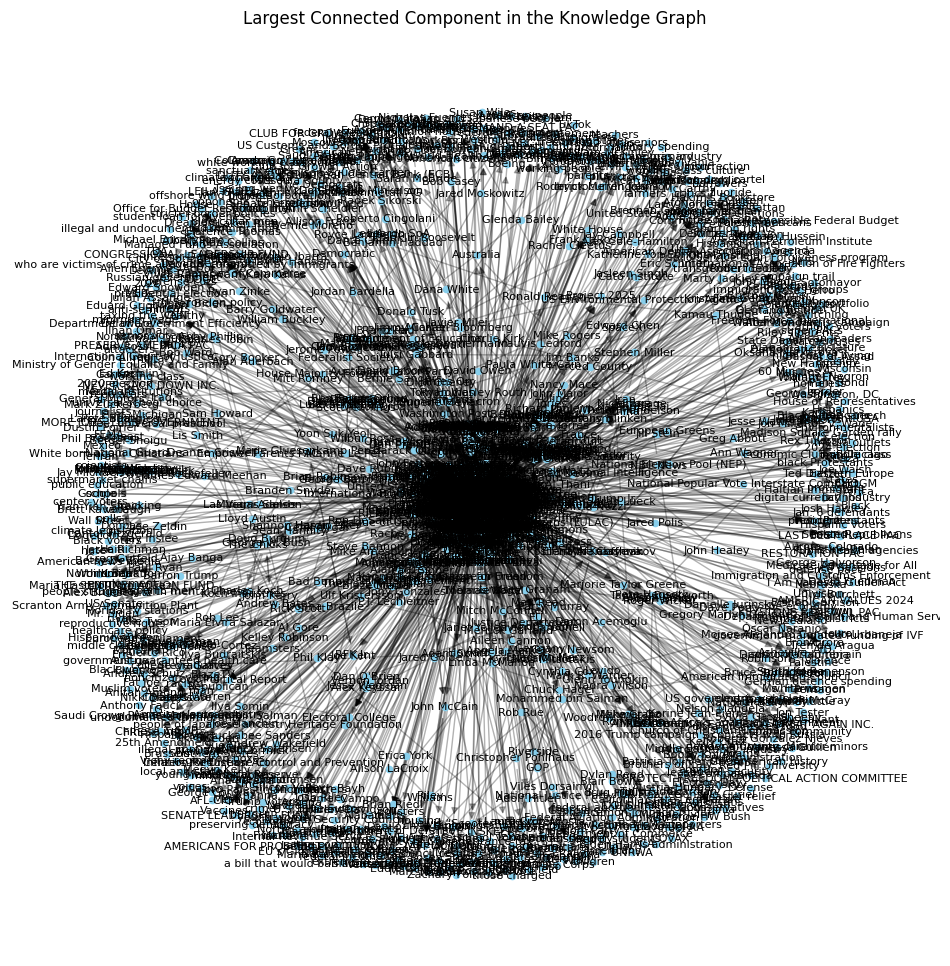

In [21]:
import matplotlib.pyplot as plt

# Find the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
subG = G.subgraph(largest_cc)

# Optional: use spring layout for nice spacing
pos = nx.spring_layout(subG, seed=42)

# Draw it
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(subG, pos, node_size=20, node_color="skyblue")
nx.draw_networkx_edges(subG, pos, alpha=0.3, arrows=True)
nx.draw_networkx_labels(subG, pos, font_size=8, font_color="black")

plt.title("Largest Connected Component in the Knowledge Graph")
plt.axis("off")
plt.show()

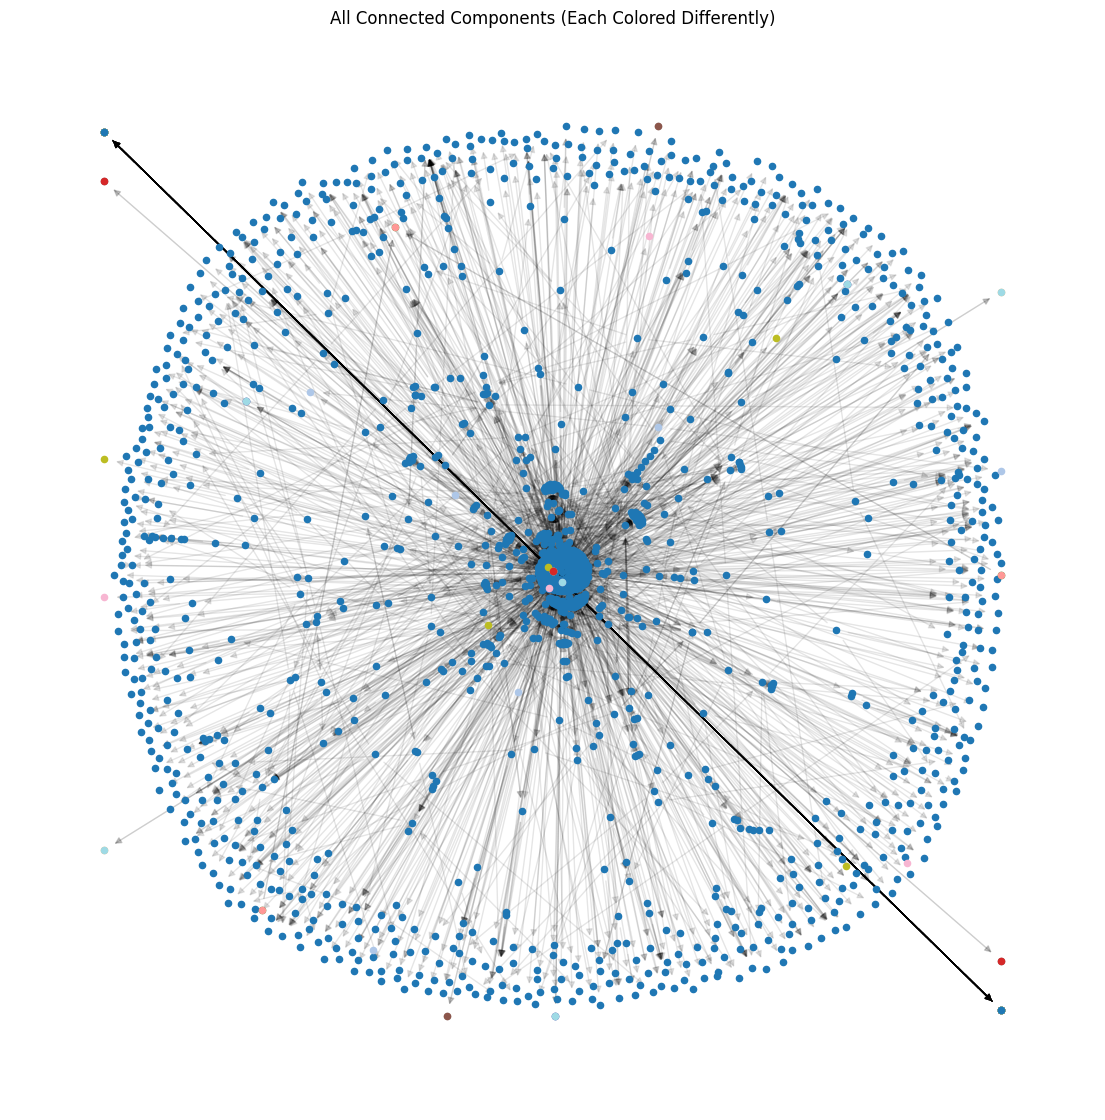

In [23]:
components = list(nx.weakly_connected_components(G))
colors = plt.cm.tab20(range(len(components)))

plt.figure(figsize=(14, 14))
for i, comp in enumerate(components):
    subG = G.subgraph(comp)
    pos = nx.spring_layout(subG, seed=42)
    nx.draw_networkx_nodes(subG, pos, node_size=20, node_color=[colors[i % 20]])
    nx.draw_networkx_edges(subG, pos, alpha=0.1)

plt.title("All Connected Components (Each Colored Differently)")
plt.axis("off")
plt.show()

avg shortest path in the largest component 


In [24]:
# Get the largest connected component (as a subgraph)
largest_cc = max(nx.weakly_connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

avg_path = nx.average_shortest_path_length(subG.to_undirected())
print("Average shortest path length (undirected):", avg_path)

Average shortest path length (undirected): 1.0


In [25]:
# Get the largest strongly connected component
strongest_cc = max(nx.strongly_connected_components(G), key=len)
subG_strong = G.subgraph(strongest_cc)

# Now this will work:
avg_path = nx.average_shortest_path_length(subG_strong)
print("Average shortest path length (strongest component):", avg_path)

Average shortest path length (strongest component): 2.7370786014486272


/var/folders/nx/lwphb_yx3312gqm2v4zgwnr00000gn/T/ipykernel_78344/3613677460.py:43: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nx/lwphb_yx3312gqm2v4zgwnr00000gn/T/ipykernel_78344/3613677460.py:43: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ghadena/Desktop/geopol/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ghadena/Desktop/geopol/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


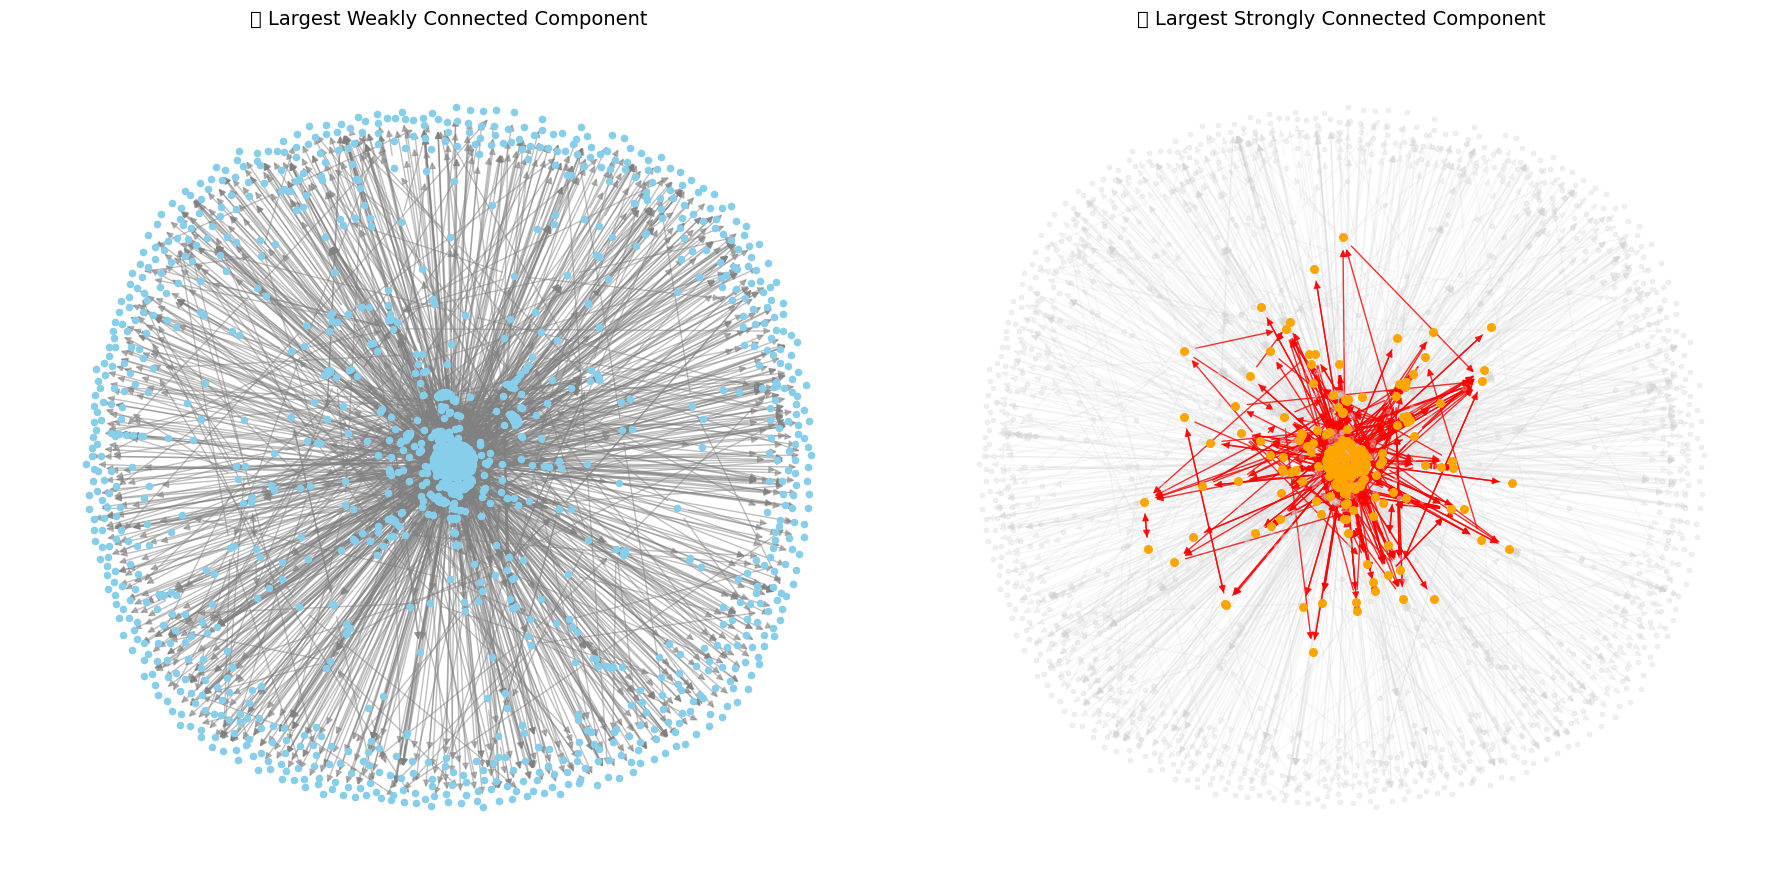

In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your edge list
edges_df = pd.read_csv("edges.csv")

# Clean column names just in case
edges_df.columns = edges_df.columns.str.strip().str.lower()

# Create a directed graph
G = nx.from_pandas_edgelist(edges_df, source="source", target="target", create_using=nx.DiGraph())

# Find the largest weakly connected component
largest_weak = max(nx.weakly_connected_components(G), key=len)
subG_weak = G.subgraph(largest_weak)

# Find the largest strongly connected component
largest_strong = max(nx.strongly_connected_components(G), key=len)
subG_strong = G.subgraph(largest_strong)

# Use spring layout for consistent node positioning
pos_weak = nx.spring_layout(subG_weak, seed=42)
pos_strong = {n: pos_weak[n] for n in subG_strong.nodes()}

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Plot largest weakly connected component
axs[0].set_title("🌐 Largest Weakly Connected Component", fontsize=14)
nx.draw_networkx_nodes(subG_weak, pos_weak, ax=axs[0], node_size=20, node_color="skyblue")
nx.draw_networkx_edges(subG_weak, pos_weak, ax=axs[0], edge_color="gray", alpha=0.5, arrows=True)
axs[0].axis("off")

# Plot strongly connected component overlaid
axs[1].set_title("🔁 Largest Strongly Connected Component", fontsize=14)
nx.draw_networkx_nodes(subG_weak, pos_weak, ax=axs[1], node_size=10, node_color="lightgray", alpha=0.3)
nx.draw_networkx_edges(subG_weak, pos_weak, ax=axs[1], edge_color="lightgray", alpha=0.2)
nx.draw_networkx_nodes(subG_strong, pos_strong, ax=axs[1], node_size=30, node_color="orange")
nx.draw_networkx_edges(subG_strong, pos_strong, ax=axs[1], edge_color="red", alpha=0.8, arrows=True)
axs[1].axis("off")

plt.tight_layout()
plt.show()

## Knowledge Graph Insights

### Node-Level Metrics

- **Donald Trump dominates the network** with the highest degree centrality (0.52), betweenness, and eigenvector centrality, indicating that he is both the most connected and the most structurally important entity.  
  **Interpretation**: He is the central figure across sources and narratives, acting as a hub of relationships.

- **Kamala Harris** ranks high in degree centrality and eigenvector score, confirming her structural importance despite appearing lower in basic ranking lists.  
  **Interpretation**: Kamala is part of multiple important sub-networks and should be considered a strategically connected actor.

- The entity **"women"** appears prominently despite having low actual connectivity (in-degree only, no out-degree).  
  **Interpretation**: Generic or thematic entities can appear frequently without meaningful structural influence. They should be analyzed separately from actors.

- **Community detection** via Louvain algorithm segments the graph into modular groups of related entities.  
  **Interpretation**: These communities reflect media-driven clusters, useful for targeted narrative or sentiment analysis.

### Graph-Level Metrics

- The graph has a **very low density** (0.0009), suggesting that while it is large, the majority of nodes are not directly connected.  
  **Interpretation**: The political discourse is fragmented, with many actors mentioned in isolation or within niche topics.

- There are **81 weakly connected components**, meaning the graph is highly fragmented when ignoring edge direction.  
  **Interpretation**: Many narratives or articles introduce new entities or local clusters without linking them to the core political discourse.

- **Average shortest path length (strongest component)** is 2.737, indicating that information within the core network can propagate within 2–3 steps.  
  **Interpretation**: This is structurally efficient; actors within this core are closely interconnected.

- **Average shortest path length (undirected)** for the largest weakly connected component is 1.0, indicating extremely tight coupling once direction is ignored.  
  **Interpretation**: The undirected structure may reflect heavy use of common hubs or recurring co-mentions, creating shortcut-rich structures.

### Structural Takeaways

- **The largest strongly connected component** (visualized in orange/red) shows a densely interconnected core that is significantly smaller than the weakly connected outer network.  
  **Interpretation**: Actionable insights should prioritize this core as the most information-rich region for classifier training and sentiment tracking.

- **Peripheral subgraphs** are disconnected from the main discourse.  
  **Interpretation**: These components may represent unique narratives, isolated events, or one-off mentions and should be analyzed for outlier patterns or emerging topics.

- **High centrality actors** should be prioritized for:
  - Node-based classification
  - Subgraph expansion
  - Temporal tracking of sentiment and relationship dynamics

## community size & composition

size
0    457
2    159
8    127
6    123
13   121
5     95
1     81
7     64
10    44
11    42

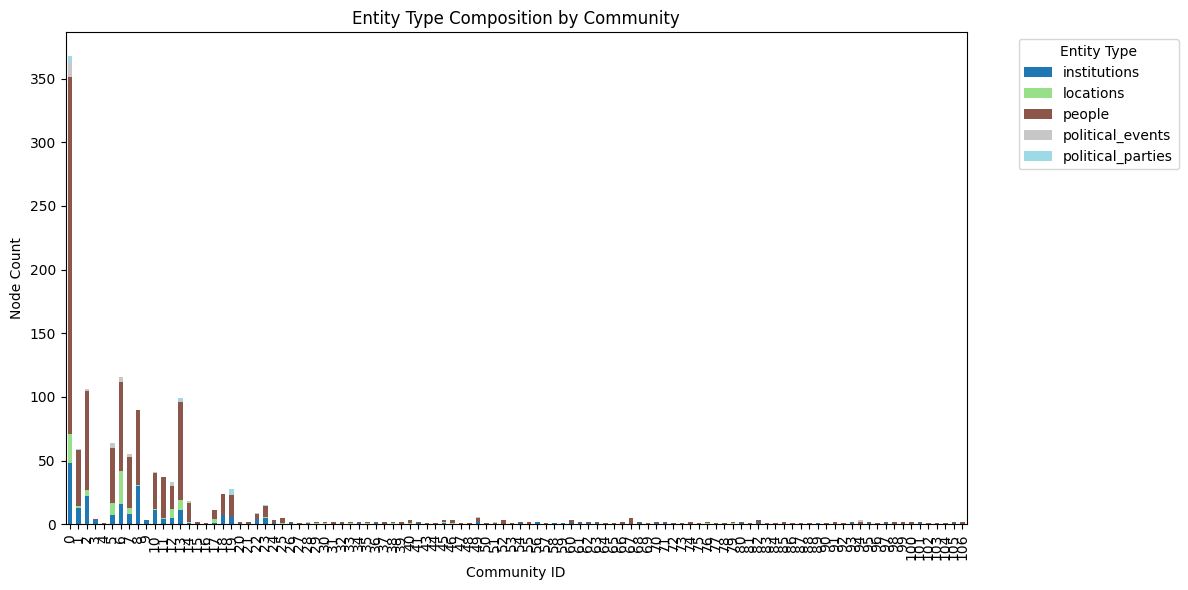

In [35]:



from collections import Counter

# Community sizes
community_sizes = Counter(partition.values())
sizes_df = pd.DataFrame.from_dict(community_sizes, orient='index', columns=["size"]).sort_values(by="size", ascending=False)
display(sizes_df.head(10))
# Distribution of entity types per community
entity_distribution = node_metrics.groupby(['community', 'type']).size().unstack(fill_value=0)
entity_distribution.sort_index().plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Entity Type Composition by Community")
plt.ylabel("Node Count")
plt.xlabel("Community ID")
plt.legend(title="Entity Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [29]:
node_metrics['community'] = node_metrics['community'].astype(int)

top_per_cluster = node_metrics.sort_values(by='degree_centrality', ascending=False).groupby('community').head(5)
top_per_cluster

entity  degree_centrality  in_degree  out_degree  \
0                     Donald Trump           0.523050        368         517   
5                    Kamala Harris           0.154846        111         151   
26                       Joe Biden           0.067967         40          75   
50                Democratic Party           0.043144         45          28   
53                Republican Party           0.040780         31          38   
..                             ...                ...        ...         ...   
758                  DEMOCRACY PAC           0.000591          1           0   
757         Fund for Policy Reform           0.000591          0           1   
792  Clark County Auditor’s office           0.000591          0           1   
790                Amanda McMillan           0.000591          1           0   
789                    Mike Benner           0.000591          1           0   

     betweenness   eigenvector  community  unnamed: 0  \
0       0.169892  3.831810e-01          0         0.0   
5       0.035606  1.485087e-01          2         1.0   
26      0.009348  1.132380e-01          5        90.0   
50      0.009827  8.681402e-02         13       124.0   
53      0.010526  8.083451e-02         13       140.0   
..           ...           ...        ...         ...   
758     0.000000  2.808239e-34         58         NaN   
757     0.000000  9.058835e-36         58      5997.0   
792     0.000000  9.058835e-36         61      6206.0   
790     0.000000  2.808239e-34         60      6186.0   
789     0.000000  2.808239e-34         60      6185.0   

                                                   url        date  \
0    https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09   
5    https://www.nytimes.com/live/2024/09/09/us/har...  2024-09-09   
26   https://www.nytimes.com/2024/09/06/us/politics...  2024-09-06   
50   https://www.nytimes.com/2024/09/10/technology/...  2024-09-10   
53   https://www.washingtonpost.com/politics/2024/0...  2024-09-09   
..                                                 ...         ...   
758                                                NaN         NaN   
757  https://www.washingtonpost.com/elections/inter...  2024-10-28   
792  https://www.cnn.com/2024/10/28/us/ballot-box-f...  2024-10-28   
790  https://www.cnn.com/2024/10/28/us/ballot-box-f...  2024-10-28   
789  https://www.cnn.com/2024/10/28/us/ballot-box-f...  2024-10-28   

                  type  
0               people  
5               people  
26              people  
50   political_parties  
53   political_parties  
..                 ...  
758                NaN  
757       institutions  
792       institutions  
790             people  
789             people  

[302 rows x 11 columns]

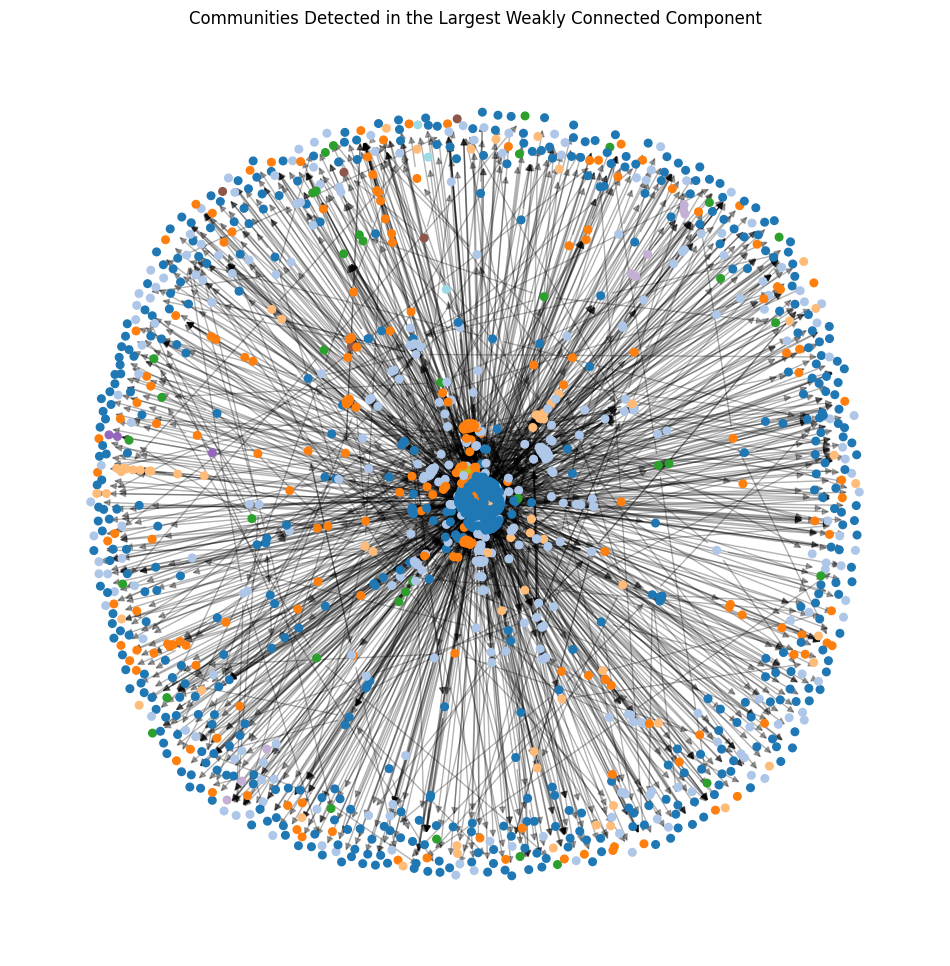

In [30]:
import matplotlib.pyplot as plt

# Color nodes by community
colors = [partition[node] for node in subG_weak.nodes()]
pos = nx.spring_layout(subG_weak, seed=42)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(subG_weak, pos, node_size=30, node_color=colors, cmap=plt.cm.tab20)
nx.draw_networkx_edges(subG_weak, pos, alpha=0.3)
plt.title("Communities Detected in the Largest Weakly Connected Component")
plt.axis("off")
plt.show()

In [31]:
def count_inter_community_edges(G, partition):
    inter_edges = 0
    for u, v in G.edges():
        if partition[u] != partition[v]:
            inter_edges += 1
    return inter_edges

inter_community_edges = count_inter_community_edges(G, partition)
print("Inter-community edges:", inter_community_edges)

Inter-community edges: 727
